We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).

**Goal**: 
- Predict conversion rate
- Come up with recommendations for the product team and the marketing team to improve conversion rate Data: Present under data/conversion_data.csv

**Table**: "conversion_data" - information about signed-in users during one session. Each row is a user session.

- country : user country based on the IP address
- age : user age. Self-reported at sign-in step
- new_user : whether the user created the account during this session or had already an account and simply came back to the site
- source : marketing channel source
  - Ads: came to the site by clicking on an advertisement
  - Seo: came to the site by clicking on search results
  - Direct: came to the site by directly typing the URL on the browser
- total_pages_visited: number of total pages visited during the session.
  - This is a proxy for time spent on site and engagement during the session.
- converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything.
  - The company goal is to increase conversion rate: # conversions / total sessions.

In [1]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt
%matplotlib inline 

from tqdm import tqdm
tqdm.pandas(desc="progress-bar", mininterval=2)

from pdpbox import pdp

/upb/users/s/ssmirnov/profiles/unix/imt/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/upb/users/s/ssmirnov/profiles/unix/imt/.local/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Read and Pre-process the data

In [2]:
df = pd.read_csv("../Conversion_rates/conversion_data.csv")
df.head(5)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [4]:
df. describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [5]:
df.isnull().values.any()

False

Looks like everything was read properly, and fortunately, there's no missing values. There are a couple things to note right away. It seems that there are a couple of invalid age entries: for intstnace at 123. This is a definetely outlier and had to be removed. Since the data set is relatively large at 316k entries, it is entirely reasonable to either delete such entries, or replace them with the median value. Let's go with substituting for the median value.

Next, we will want to plot some simple relationships as part of an exploratory analysis.

Additionally, we will need to encode the country and source information as numerics. Pandas has a super-convenient DataFrame method called get_dummies that we'll use for this.

Finally, it looks like our total conversions are around 3.22%. The goal of the exercise is to report some ways to incresse this to the marketing team, so we need to keep that goal in mind.

In [6]:
# Substitute enormously high 'age' entries (> 90) with the median over the column.   

df.loc[df["age"] > 90, "age"] = int(df.age.median())
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569307,0.685465,4.872966,0.032258
std,8.268932,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,79.000000,1.000000,29.000000,1.000000


### EDA


In [7]:
df['converted'].value_counts()

0    306000
1     10200
Name: converted, dtype: int64

We should notice that the dataset is extremely imbalanced (only around 3% of all samples have labeled 'converted'), therefore we may need to analyze another metric, besides 'Accuracy'.

First let's make a table of the conversion rate and total site visits grouped by country:

In [8]:
# We have got four countries in our dataset

df.country.unique()

array(['UK', 'US', 'China', 'Germany'], dtype=object)

In [9]:
df[["country","converted"]].groupby(["country"]).agg(["mean","count"])

converted        
             mean   count
country                  
China    0.001332   76602
Germany  0.062500   13056
UK       0.052632   48450
US       0.037801  178092

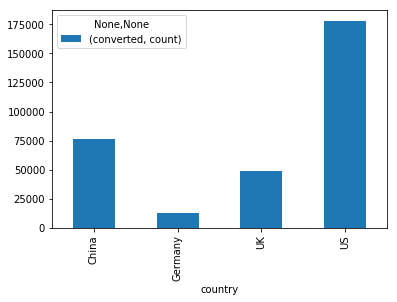

In [10]:
df[["country","converted"]].groupby(["country"]).agg(["count"]).plot(kind='bar')

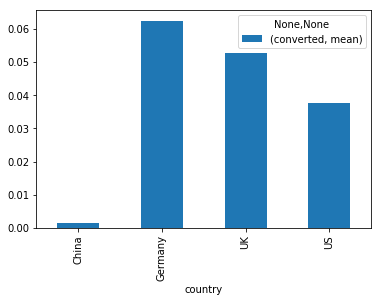

In [11]:
df[["country","converted"]].groupby(["country"]).agg(["mean"]).plot(kind='bar')

So Germany has the highest conversion rate, but the fewest customers. China's conversion rate is very low, and yet they have the second-most customers. Already we can tell that **perhaps there's a problem for Chinese users of the site.**

Next, let's look at age and plot the results (since there's far more possible values of ages than countries).

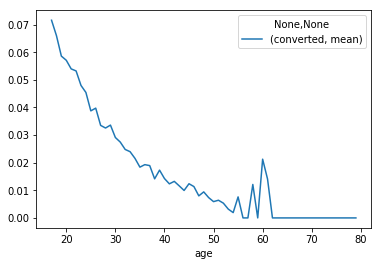

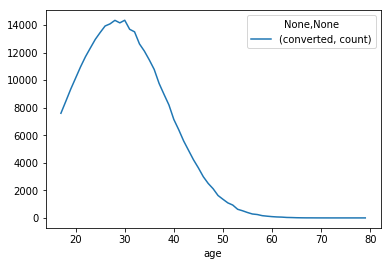

In [12]:
df[['age', 'converted']].groupby(['age']).agg(['mean']).plot()
df[['age', 'converted']].groupby(['age']).agg(['count']).plot()

It looks like younger users will tend to buy more frequently and the conversion rate decreases nearly monotonically with age, but the peak of the distribution of site visitors occurs around ~30 years. It can be observed that there is nearly no "conversion" from users which are older than 60.

Lastly, let's look at total pages visited.

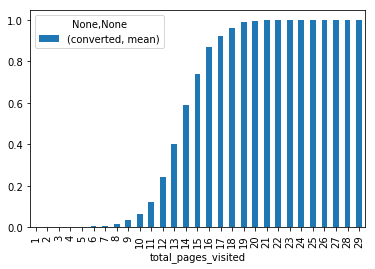

In [13]:
df[['total_pages_visited', 'converted']].groupby(['total_pages_visited']).agg(['mean']).plot(kind="bar")

Here we see a very clear trend that the more time a user spends on a site, the more likely they are to buy something. The inflection point is about ~15 pages.

### Model building

First of all we need to transform categorical features, since most of the ML algorithms can not work with them properly.

In [14]:
df = pd.get_dummies(df)
df.head()

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,0,1,0,1,0,0
1,23,1,5,0,0,0,0,1,0,0,1
2,28,1,4,0,0,0,0,1,0,0,1
3,39,1,5,0,1,0,0,0,0,0,1
4,30,1,6,0,0,0,0,1,0,0,1


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 11 columns):
age                    316200 non-null int64
new_user               316200 non-null int64
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
country_China          316200 non-null uint8
country_Germany        316200 non-null uint8
country_UK             316200 non-null uint8
country_US             316200 non-null uint8
source_Ads             316200 non-null uint8
source_Direct          316200 non-null uint8
source_Seo             316200 non-null uint8
dtypes: int64(4), uint8(7)
memory usage: 11.8 MB


Our next job will be to split the data into four training and one testing sets using k-fold cross validation later we split into X (features) and Y (targets). Additionally, now's the time to convert the pandas dataframe into numpy array which the XGBoost classifier will use.

In [16]:
Y = df["converted"].values
X = df.drop("converted", axis=1).values

kf = KFold(n_splits=5, shuffle=True, random_state=17)

In [17]:
Y

array([0, 0, 0, ..., 0, 0, 0])

In [18]:
acc_results = []
imp_results = []
average_precision = []
model = XGBClassifier()
# "Error_function" can be replaced by the error function of your analysis
for traincv, testcv in kf.split(X):
        prediction = model.fit(X[traincv], Y[traincv]).predict(X[testcv])
        acc_results.append(accuracy_score(Y[testcv], prediction))
        average_precision.append(average_precision_score(Y[testcv], prediction))
        imp_results.append(model.feature_importances_.tolist())
        
print("Accuracy results: " + str( np.array(acc_results).mean()))
print('Average Precision score:' +  str( np.array(average_precision).mean()))

Accuracy results: 0.9860404807084124
Average Precision score:0.5942406191262642


In [19]:
avg_importance = map(np.mean, zip(*imp_results))
avg_importance

[0.15655531585216523,
 0.17735562920570375,
 0.5124274492263794,
 0.10369951277971268,
 0.015782304853200913,
 0.00233460133895278,
 0.018408271297812463,
 0.004088938771747053,
 0.009055162500590085,
 0.0002928257687017322]

Now, visualize the relative importances for each feature on the target. Keep in mind that this model is preliminary; i.e. we would ideally like to create a more fine-grained model and optimize parameters in a moment.

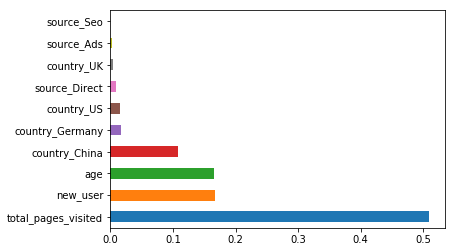

In [20]:
features = df.drop("converted", axis=1).columns.values
pd.Series(model.feature_importances_, index=features).nlargest(12).plot(kind='barh')

So, total_pages_visited seems to be the most important in predicting conversions. Sources, as a whole, seem to be the least important. The first four features in our DataFrame have much higher importance than the rest. However, the number of pages visited by a user, despite being the highest predictor of conversions, is probably the feature that we have the least control over from a site perspective.


Let's take a closer look by building the model again without cross-validation and also without the total_pages_visited feature, and by calling xgboost in a slightly different way. We'll also use PDPbox to sort through the partial dependence plots.

In [21]:
train = df.drop(["total_pages_visited"], axis=1)
y = df.converted.values # Target vector
target = 'converted' # Target column
IDcol = 'ID'
train, test = train_test_split(train, test_size = 0.2)
# bst_cv = xgb.cv(params, Y, 500, nfold=5, early_stopping_rounds=10)

In [22]:
# Columns which participate in training

predictors_columns = [x for x in train.columns if x not in [target, IDcol]] 

xgb1 = XGBClassifier()

xgb_param = xgb1.get_xgb_params()

xgtrain = xgb.DMatrix(train[predictors_columns].values, label=y)

# Define cross-validation for XGB parameters
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb1.get_params()['n_estimators'], nfold=4,
            metrics='auc', early_stopping_rounds=50)

xgb1.set_params(n_estimators=cvresult.shape[0])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=37,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [23]:
#Fit the algorithm on the data and pre-defined parameters

xgb1.fit(train[predictors_columns], train[target],eval_metric='auc')

#Predict training set:
train_predictions = xgb1.predict(train[predictors_columns])
train_predprob = xgb1.predict_proba(train[predictors_columns])[:,1]      


#Print model report:

print("\nModel Report")
print("Accuracy : %.4g" % accuracy_score(train[target].values, train_predictions))
print('Average Precision Score: %f' % average_precision_score(train[target].values, train_predictions)) 
print("AUC Score (Train): %f" % roc_auc_score(train[target], train_predprob))



Model Report
Accuracy : 0.9679
Average Precision Score: 0.032143
AUC Score (Train): 0.814844


Average Precision fell down to 0.0323, and accuracy is around 96.7% which clearly indicates that the model without `total_pages_visited` feature is not able to classify converted samples and always say 'not converted'.

In [24]:
xgb1.get_booster().get_fscore()

{'age': 84, 'country_China': 69, 'country_US': 4, 'new_user': 42}

Text(0,0.5,'Feature Importance Score')

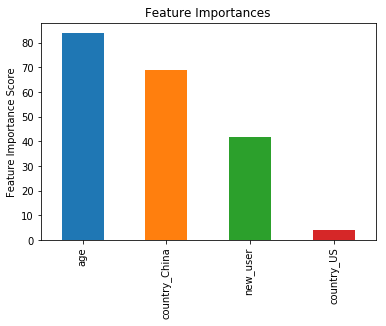

In [25]:
# Feature Importance

feature_imp = pd.Series(xgb1.get_booster().get_fscore()).sort_values(ascending=False)
feature_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

The one can see that without the `total_pages_visited` feature, we reduce the accuracy from ~98.6% to ~96.7%. The problem with that accuracy is  that since this is an imbalanced classification problem, if we group every record as 'NOT converted', we can still get 96.7% accuracy. Hovewer, since our first model produces an accurancy as 98.6% on test dataset, which indicates it is a model which makes sense.

from above model, we can draw below conclusion:

- `total_pages_visited` is a most important feature. The longer the user browse our web page, the more likely he/she will convert and buy something. Then if we find some user browse a lot and didn't buy anything, we can send email to remaind them.

- Conversion among China users are very bad even though there are lot of users coming from China. Consider China's economic and population, there is a huge opportunity if we target Chinese users and improve their conversion rate. We should consider whether our website has good Chinese translation and satisfy Chinese users' culture requirement.

- Conversion from Germany is good but thre isn't a lot of users from German. Therefore it's a huge opportuntity for us to target German users. For example, put more advertisement in German.

- `Age` is a negative factor. The older the user is, the less likely he/she will convert. Then we should figure out why young people loves the web pages and strengthen it. And also find out why older people doesn't like our web pages, and try to correct it.

